In [1]:
import praw
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import nltk
import seaborn as sns
import pyLDAvis.gensim_models
from wordcloud import WordCloud
import gensim
import string
from nltk.tokenize import word_tokenize
#nltk.download('punkt_tab')
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [3]:
#Storing search data in posts, comments and subreddits data frame
posts = pd.DataFrame(columns = ["title","body", "subreddit_id", "comment_count", "date"])
comments = pd.DataFrame(columns = ["post_id", "body", "upvotes", "date"])
subreddits_ = pd.DataFrame(columns = ["name","subscriber_count"])

for result in CommBank_search:
    posts.loc[result.id, "title"] = result.title
    posts.loc[result.id,"body"] = result.selftext
    posts.loc[result.id, "subreddit_id"] = result.subreddit.id
    posts.loc[result.id, "comment_count"] = result.num_comments
    posts.loc[result.id, "date"] = datetime.datetime.fromtimestamp(result.created_utc)

    #inserting subreddit data
    subreddits_.loc[result.subreddit.id, "name"] = result.subreddit.name
    subreddits_.loc[result.subreddit.id, "title"] = result.subreddit.title
    subreddits_.loc[result.subreddit.id, "display"] = result.subreddit.display_name
    subreddits_.loc[result.subreddit.id, "subscriber_count"] = result.subreddit.subscribers
    
    result.comments.replace_more(limit=0)
    
    #making comments in the same loop
    for comment in result.comments:
        comments.loc[comment.id, "post_id" ] = result.id
        comments.loc[comment.id, "body"] = comment.body
        comments.loc[comment.id, "upvotes"] = comment.score
        comments.loc[comment.id, "date"] = datetime.datetime.fromtimestamp(comment.created_utc)

In [124]:
#Making copies of each because reloading takes a long times
posts_df = posts 
comments_df = comments
subreddits_df = subreddits_

# Initial EDA 
## Investigating subreddits with most activity

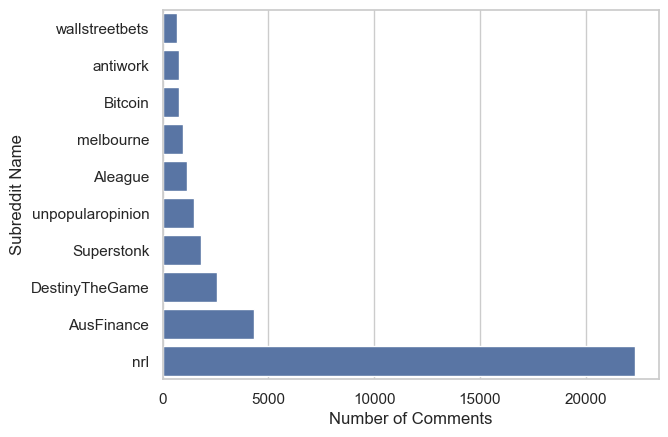

In [125]:
sns.barplot(orient = 'h', data = posts_df.merge(subreddits_df.display, how = 'left', left_on = 'subreddit_id', right_index = True).groupby('display').comment_count.sum().sort_values()[-10:])
plt.ylabel("Subreddit Name")
plt.xlabel("Number of Comments")
plt.show()

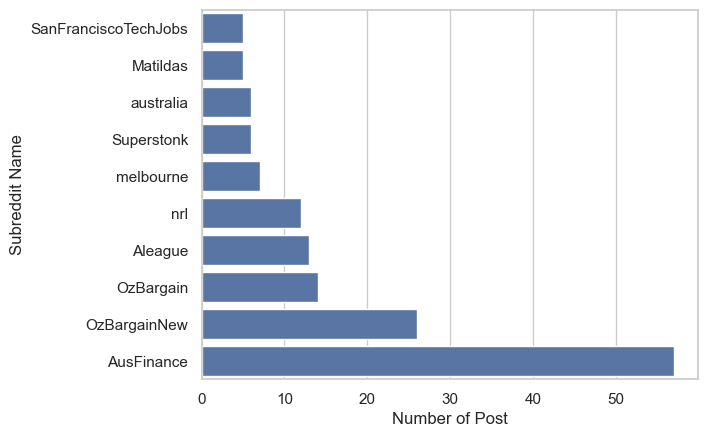

In [126]:
sns.barplot(orient = 'h', data = posts_df.merge(subreddits_df.display, how = 'left', left_on = 'subreddit_id', right_index = True).groupby('display').display.value_counts().sort_values()[-10:])
plt.ylabel("Subreddit Name")
plt.xlabel("Number of Post")
plt.show()

## Daily Activity Trend

In [127]:
data = pd.concat([posts_df.loc[:,"date"], comments_df.loc[:,"date"]])
day = data.apply(lambda dt: pd.to_datetime(dt).round('D'))
data = pd.DataFrame({"date": data, "day": day})


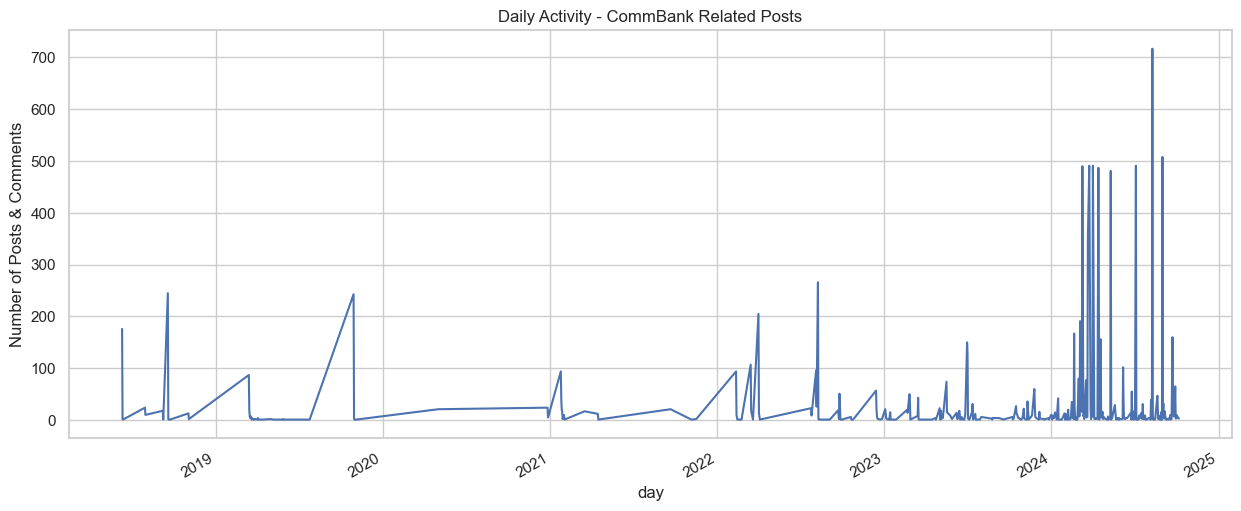

In [128]:
data.groupby("day").date.count().plot(figsize = (15,6))
plt.title("Daily Activity - CommBank Related Posts")
plt.ylabel("Number of Posts & Comments")
plt.show()

## Preprocessing

### Removing posts from subreddits related to sports

The initial analysis revealed that a few posts were made in sports-related subreddits, highlighting how Commbank's involvement in sports enhances its brand visibility. Commbank has a rugby stadium named after it and also sponsors national teams in football and cricket. However, this analysis focused on the bank’s core business, so posts from sports-related subreddits were excluded. 

In [129]:
sports_subreddits= ['2qn90', '2qiel', '2s6c7', '2vq0w', '2qkbe', '24d2qr', '2sr4p', '4qtc8b', '2qi58', '2hqqj5']

# Remove rows with specified subreddit IDs
posts_df = posts_df[~posts_df['subreddit_id'].isin(sports_subreddits)]

#Update comments to be from only non sports posts
comments_df = comments_df[comments_df.post_id.isin(posts_df.index)]


### Dropping Duplicates to reduce spam posts included


In [130]:
posts_df.drop_duplicates(subset = ["body"], inplace = True)
comments_df.drop_duplicates(subset = ["body"], inplace = True)

C:\Users\lebom\AppData\Local\Temp\ipykernel_17888\1328416341.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  posts_df.drop_duplicates(subset = ["body"], inplace = True)
C:\Users\lebom\AppData\Local\Temp\ipykernel_17888\1328416341.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comments_df.drop_duplicates(subset = ["body"], inplace = True)


### Making sure that posts truly contain phrases 'commbank' or 'commonwealth bank'

In [131]:
#Combining the Title & Body for Posts and Making All text into one dataframe
posts_df['title_body'] = posts.title + ' ' + posts.body


#Removing Punctuation
posts_df['title_body'] = posts_df.title_body.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))


#Making Lowercase
posts_df['title_body'] = posts_df.title_body.apply(lambda x: x.lower())


#checking for text that strictly says commonwealth bank or commbank 

posts_df = posts_df[posts_df.title_body.apply(lambda x: ('commonwealth bank' in x) or ('commbank' in x))]


C:\Users\lebom\AppData\Local\Temp\ipykernel_17888\3173952946.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  posts_df['title_body'] = posts.title + ' ' + posts.body
C:\Users\lebom\AppData\Local\Temp\ipykernel_17888\3173952946.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  posts_df['title_body'] = posts_df.title_body.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
C:\Users\lebom\AppData\Local\Temp\ipykernel_17888\3173952946.py:10: SettingWithCopyWarning: 
A value is trying to

In [132]:
#making sure the comments are from the remaining posts
comments_df = comments_df[comments_df.post_id.isin(posts_df.index)]
comments_df['body'] = comments_df.body.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
comments_df['body'] =comments_df.body.apply(lambda x: x.lower())

## Analysising sentiment

In [133]:
sia_obj = SentimentIntensityAnalyzer()
comments_df['sentiments'] = comments_df.body.apply(sia_obj.polarity_scores).apply(lambda score: score.get('compound'))
posts_df['sentiments'] = posts_df.title_body.apply(sia_obj.polarity_scores).apply(lambda score: score.get('compound'))

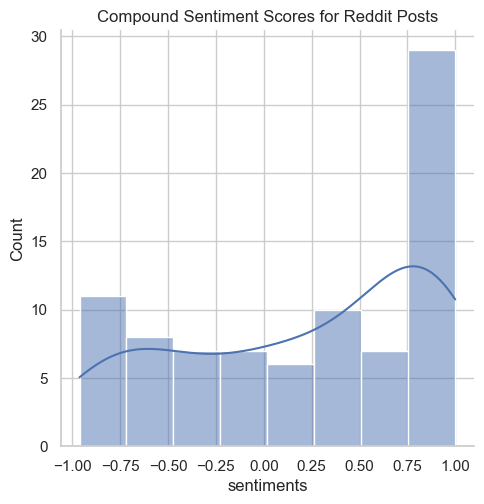

In [134]:
sns.displot(posts_df.sentiments, kde = True)
sns.set_style('whitegrid')
plt.title("Compound Sentiment Scores for Reddit Posts")
plt.show()

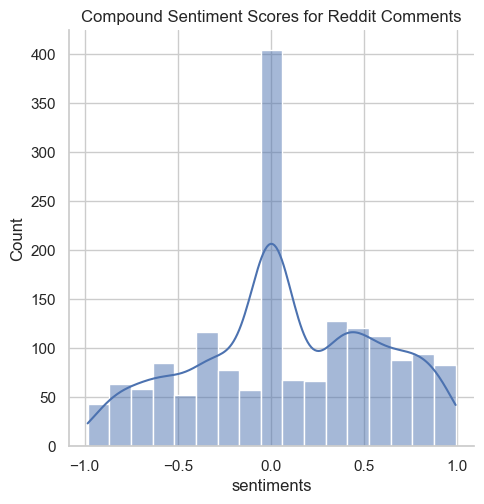

In [135]:
sns.displot(comments_df.sentiments, kde = True)
sns.set_style('whitegrid')
plt.title("Compound Sentiment Scores for Reddit Comments")
plt.show()

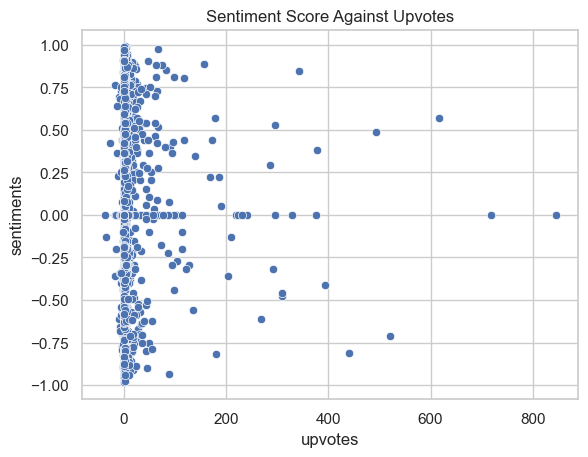

In [136]:
sns.set_style('whitegrid')
sns.scatterplot(data = comments_df, x = 'upvotes', y = 'sentiments')
plt.title("Sentiment Score Against Upvotes")
plt.show()

### Implement Community Pooling

I implemented community pooling by combining a post and its comments into a single document. This could strengthen the LDA (Latent Dirichlet Allocation) analysis because it captures the full context and discussion around each topic. By aggregating comments with the original post, we ensure that the complete range of perspectives, sentiments, and nuances is included, leading to a more accurate and representative topic model. 

In [137]:
#Group comments by post_id and then concatenate each 
grouped_comments = comments_df.groupby('post_id')['body'].agg('\n'.join)
posts_comments = posts_df.merge(grouped_comments, how='left', left_index = True, right_index = True)

comments_sentiment = comments_df.groupby('post_id')['sentiments'].mean()
posts_comments = posts_comments.merge(comments_sentiment, how='left', left_index = True, right_index = True)

In [138]:
posts_comments.head()

,title,body_x,subreddit_id,comment_count,date,title_body,sentiments_x,body_y,sentiments_y
wgnxs7,Commbank charged my fiancée $4 in bank fees be...,"Both lifelong customers, it was the small push...",2uo3q,530,2022-08-04 23:22:50,commbank charged my fiancée 4 in bank fees bec...,-0.3182,i remember when it was pretty amazing that anz...,0.109030
11bgj57,the line to open a bank account at commbank on...,,2qkhb,420,2023-02-25 01:01:55,the line to open a bank account at commbank on...,0.0000,this is why businesses wanted international st...,0.097672
1bqij38,Commonwealth Bank claim they had sent me a six...,"Late last year, I fell victim to phone scammer...",2uo3q,346,2024-03-28 23:37:08,commonwealth bank claim they had sent me a six...,-0.7408,it’s more like the ‘payment’ screen setup by t...,-0.104124
1c64a8h,Why do people bank with CommBank?,"The big 4 seem to be expensive, useless, diffi...",2uo3q,134,2024-04-17 01:02:50,why do people bank with commbank the big 4 se...,-0.6486,inertia people started with their accounts for...,0.311362
17sotc9,CommBank fraud attempt,I got a text telling me someone had changed my...,2uo3q,96,2023-11-10 22:40:51,commbank fraud attempt i got a text telling me...,-0.1426,hey mate ive worked for cba if a staff member ...,-0.073892


In [139]:
posts_comments['title_body_comments'] = posts_comments.title_body + ': ' + posts_comments['body_y']

In [140]:
#finally dropping nas
posts_comments.dropna(how='any',axis=0, inplace = True)

## Wordcloud EDA

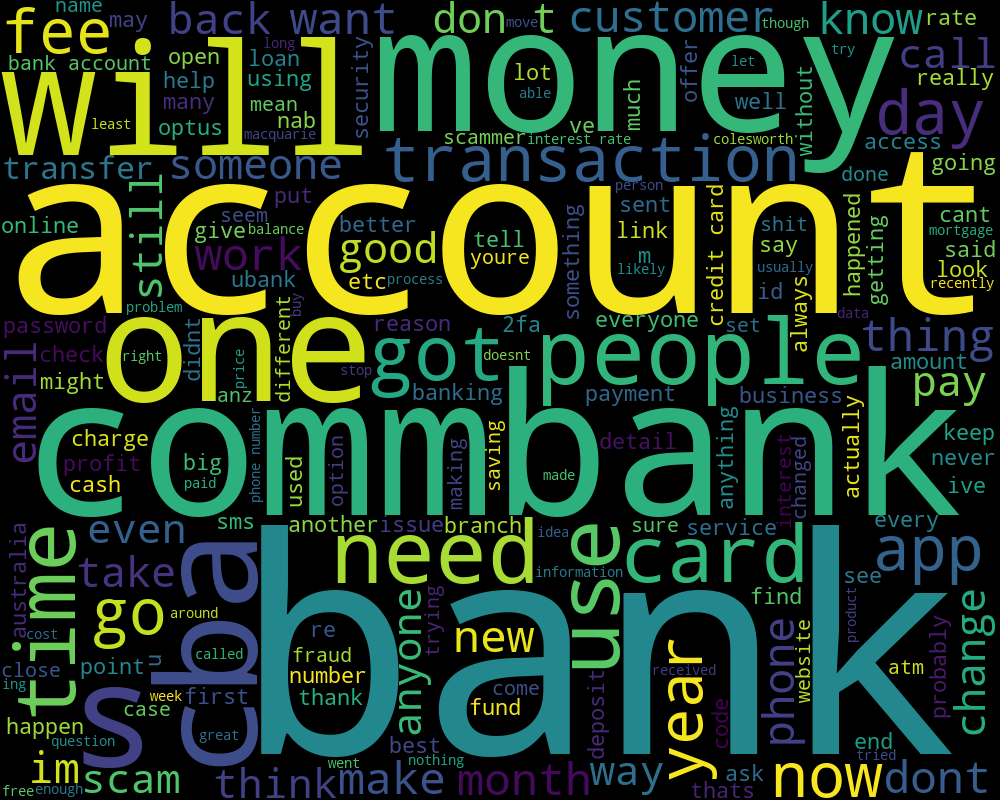

In [141]:
sample_string = ','.join(list(posts_comments.title_body_comments))

sample_wordcloud = WordCloud(width = 1000, height = 800)

sample_wordcloud.generate(sample_string)
sample_wordcloud.to_image()

In [15]:
#Frequent words

In [57]:
noisy_words = ["like", "get", "one", "gets", "would", "dont", "people", "time", "im", "got", "want", "use", "make", "see", "going", "go", "fuck", "shit",\
           "also", "fucking", "could", "still", "really", "should", "ive", "u", "us", "much", "lol", "na", "commonwealth", "bank", "commbank", "banks", \
              "anyone", "everyone", "someone", "actually", "cant", "something", "etc", "anything", "cba", "account", "money", "accounts", "need", "back", \
               "good", "know", "number", "app", "phone", "card", "accounts", "credit", "month", "think", "thing", "work", "think", "new", "call", "day", "even", "never",\
               "cash", "banking", "big", "years", "first", "said", "details", "id", "probably"]

   
def remove_stopwords(text):
    tokens = word_tokenize(text)
    english_stopwords = stopwords.words('english') + noisy_words
    tokens_wo_stopwords = [t for t in tokens if t not in english_stopwords]
    return " ".join(tokens_wo_stopwords)

text_df = posts_comments.title_body_comments.apply(lambda text: remove_stopwords(text))
text_df_og = text_df

In [58]:
text_df = text_df.apply(lambda sentence: gensim.utils.simple_preprocess(str(sentence), deacc= True))

In [59]:
#LDA
#Create Dictionary
id2word = gensim.corpora.Dictionary(text_df)

corpus = [id2word.doc2bow(text) for text in text_df]

num_topics = 8

#build model
lda_model = gensim.models.LdaMulticore(corpus = corpus, id2word = id2word, num_topics = num_topics)

In [60]:
from pprint import pprint
pprint(lda_model.print_topics())

[(0,
  '0.003*"transactions" + 0.003*"interest" + 0.003*"transaction" + '
  '0.003*"fees" + 0.003*"code" + 0.003*"happened" + 0.003*"take" + '
  '0.003*"transfer" + 0.003*"pay" + 0.002*"free"'),
 (1,
  '0.004*"pay" + 0.003*"fees" + 0.003*"online" + 0.003*"take" + '
  '0.003*"transaction" + 0.003*"interest" + 0.003*"transactions" + '
  '0.003*"loan" + 0.003*"change" + 0.003*"every"'),
 (2,
  '0.008*"points" + 0.004*"optus" + 0.003*"way" + 0.003*"qantas" + '
  '0.003*"using" + 0.003*"point" + 0.002*"pay" + 0.002*"award" + '
  '0.002*"awards" + 0.002*"data"'),
 (3,
  '0.003*"loan" + 0.003*"well" + 0.003*"fees" + 0.003*"rate" + 0.003*"take" + '
  '0.003*"interest" + 0.003*"every" + 0.002*"customers" + 0.002*"change" + '
  '0.002*"ago"'),
 (4,
  '0.004*"interest" + 0.003*"email" + 0.003*"branch" + 0.003*"online" + '
  '0.003*"change" + 0.003*"ago" + 0.002*"anz" + 0.002*"take" + 0.002*"best" + '
  '0.002*"transfer"'),
 (5,
  '0.004*"interest" + 0.003*"online" + 0.003*"way" + 0.003*"fees" + '

## Suggested Topics

| Topic Number | Associated Words                                                                                   | Suggested Topic                          |
|--------------|----------------------------------------------------------------------------------------------------|------------------------------------------|
| 0            | transactions, interest, transaction, fees, code, happened, take, transfer, pay, free               | Transaction Details and Transfer Issues  |
| 1            | pay, fees, online, take, transaction, interest, transactions, loan, change, every                  | Online Transactions and Loan Services    |
| 2            | points, optus, way, qantas, using, point, pay, award, awards, data                                 | Loyalty Programs and Rewards             |
| 3            | loan, well, fees, rate, take, interest, every, customers, change, ago                              | Loan Interest Rates and Customer Impact  |
| 4            | interest, email, branch, online, change, ago, anz, take, best, transfer                            | Online and Branch Banking Services       |
| 5            | interest, online, way, fees, pay, using, may, transaction, might, payment                          | Online Payment Methods and Options       |
| 6            | interest, pay, fa, fees, business, using, best, free, password, change                             | Business Accounts and Payment Security   |
| 7            | interest, optus, rate, change, nab, better, fees, data, pay, take                                  | Bank Rates and Competitive Positioning   |



In [61]:
topic_assignments = []
for sentence_bow in corpus:
    topic_distribution = lda_model.get_document_topics(sentence_bow)
    # Get the topic with the highest probability
    assigned_topic = max(topic_distribution, key=lambda x: x[1])[0]
    topic_assignments.append(assigned_topic)

In [144]:
posts_comments['topic'] = topic_assignments

### Visualzing Post Sentiment By Topic

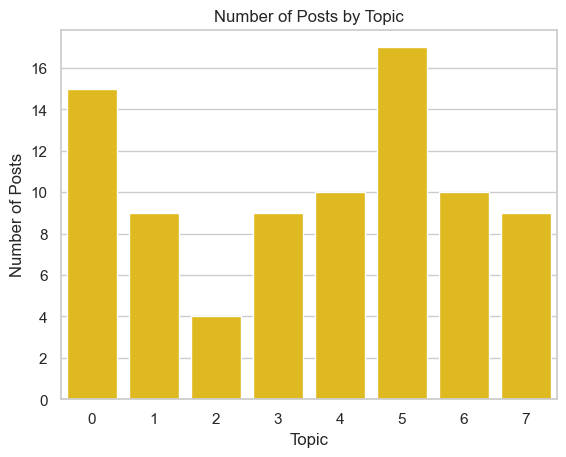

<Figure size 640x480 with 0 Axes>

In [142]:
sns.barplot(pd.Series(topic_assignments).value_counts(), color = '#FFCC00')
plt.xlabel("Topic")
plt.ylabel("Number of Posts")
plt.title("Number of Posts by Topic")
plt.show()
plt.savefig('plot1.png')

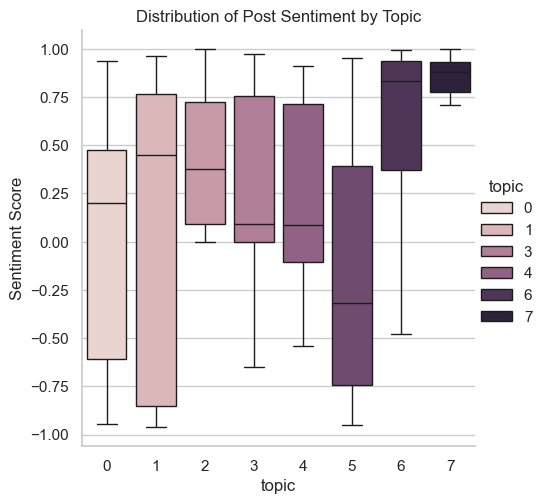

In [145]:
sns.set(style="whitegrid")
sns.catplot(x="topic", y="sentiments_x", hue = 'topic', kind="box", data=posts_comments)
plt.title('Distribution of Post Sentiment by Topic')
plt.ylabel('Sentiment Score')
plt.savefig('plot2.png')
plt.show()

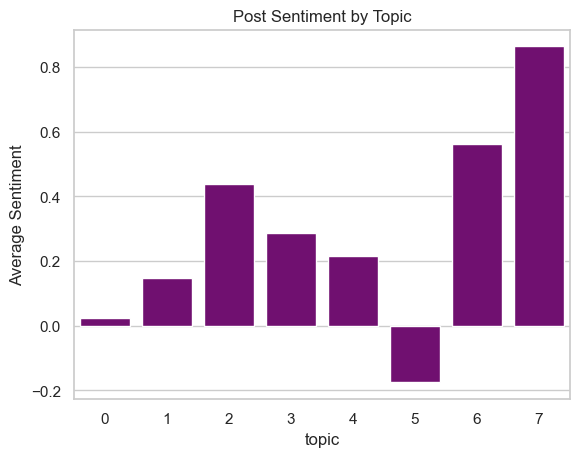

In [146]:
sns.barplot(data = posts_comments.groupby('topic').sentiments_x.mean(), color = "purple")
plt.ylabel('Average Sentiment')
plt.title('Post Sentiment by Topic')
plt.savefig('plot3.png')
plt.show()

In [147]:
posts_comments.groupby('topic').sentiments_x.mean()

topic
0    0.023980
1    0.147022
2    0.437600
3    0.286511
4    0.216010
5   -0.175900
6    0.560450
7    0.863656
Name: sentiments_x, dtype: float64

In [96]:
posts_comments[posts_comments.topic == 7].sentiments_x.describe()

count    9.000000
mean     0.863656
std      0.109016
min      0.709600
25%      0.774300
50%      0.880400
75%      0.933700
max      0.999500
Name: sentiments_x, dtype: float64

### Visualizing Comment Sentiment by Topic

In [148]:
#Assigning Topics to comments
comments_topics= comments_df.merge(posts_comments.topic, how = 'left', left_on = 'post_id', right_index = True )
comments_topics.head(2)

,post_id,body,upvotes,date,sentiments,topic
ij0wzv9,wgnxs7,i remember when it was pretty amazing that anz...,617,2022-08-05 00:15:53,0.5710,5
ij13mii,wgnxs7,when i was a kid i opened my first account wit...,114,2022-08-05 01:43:52,-0.2023,5


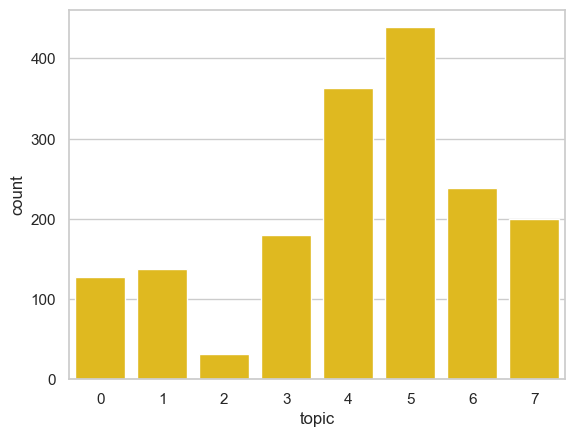

In [149]:
sns.barplot(comments_topics.groupby('topic').topic.value_counts(), color = "#FFCC00")
plt.savefig('plot4.png')
plt.show()

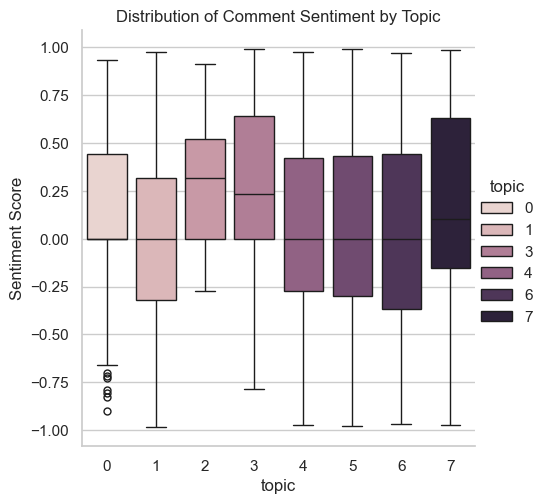

In [150]:
sns.set(style="whitegrid")
sns.catplot(x="topic", y="sentiments", hue = 'topic', kind="box", data=comments_topics)
plt.title('Distribution of Comment Sentiment by Topic')
plt.ylabel('Sentiment Score')
plt.savefig('plot5.png')
plt.show()

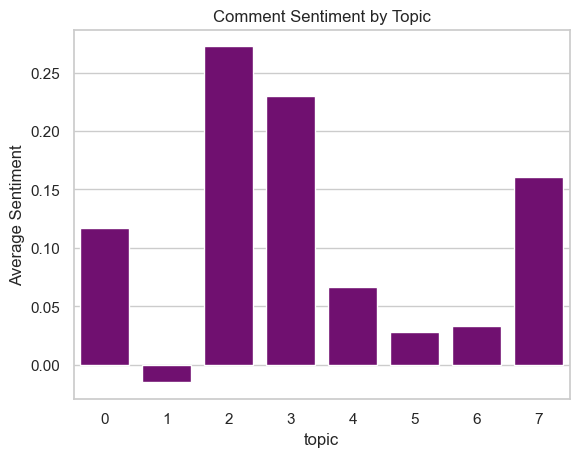

In [151]:
sns.barplot(data = comments_topics.groupby('topic').sentiments.mean(), color = "purple")
plt.ylabel('Average Sentiment')
plt.title('Comment Sentiment by Topic')
plt.savefig('plot6.png')
plt.show()

In [75]:
comments_topics[comments_topics.topic == 0].sentiments.describe()

count    128.000000
mean       0.116761
std        0.437668
min       -0.897400
25%        0.000000
50%        0.000000
75%        0.440400
max        0.931100
Name: sentiments, dtype: float64

In [76]:
comments_topics[comments_topics.topic == 1].sentiments.describe()

count    137.000000
mean      -0.015082
std        0.451603
min       -0.984100
25%       -0.319300
50%        0.000000
75%        0.316700
max        0.975500
Name: sentiments, dtype: float64

In [77]:
comments_topics[comments_topics.topic == 2].sentiments.describe()

count    31.000000
mean      0.272377
std       0.328414
min      -0.273200
25%       0.000000
50%       0.318200
75%       0.518650
max       0.909100
Name: sentiments, dtype: float64

In [78]:
comments_topics[comments_topics.topic == 3].sentiments.describe()

count    180.000000
mean       0.229968
std        0.473367
min       -0.784500
25%        0.000000
50%        0.235600
75%        0.638375
max        0.987300
Name: sentiments, dtype: float64

In [79]:
comments_topics[comments_topics.topic == 4].sentiments.describe()

count    363.000000
mean       0.066092
std        0.459698
min       -0.974500
25%       -0.273200
50%        0.000000
75%        0.418750
max        0.972000
Name: sentiments, dtype: float64

In [74]:
comments_topics[comments_topics.topic == 5].sentiments.describe()

count    439.000000
mean       0.027714
std        0.513315
min       -0.976100
25%       -0.301550
50%        0.000000
75%        0.430950
max        0.990300
Name: sentiments, dtype: float64

In [80]:
comments_topics[comments_topics.topic == 6].sentiments.describe()

count    239.000000
mean       0.032792
std        0.533145
min       -0.969000
25%       -0.367050
50%        0.000000
75%        0.440400
max        0.967000
Name: sentiments, dtype: float64

In [81]:
comments_topics[comments_topics.topic == 7].sentiments.describe()

count    200.000000
mean       0.160669
std        0.507163
min       -0.970500
25%       -0.153100
50%        0.102700
75%        0.627900
max        0.983700
Name: sentiments, dtype: float64

### Discussion of Results

### Potential Improvement Area Topic:

**Topic 5**: Out of the 86 posts analyzed, *15* are classified under Topic 5, which is the highest number for any topic. This topic also has the most comments associated with it. The suggested theme for Topic 5 is "Online Payment Methods and Options," which appears to generate relatively negative sentiment. The average comment sentiment for Topic 5 ranks as the second lowest, with a median comment sentiment of 0, indicating a general neutrality or slight negativity among comments. Furthermore, the average post sentiment for Topic 5 is the only one with a negative value, and the median post sentiment is also negative. This suggests that at least half of the posts in this topic have a negative sentiment, indicating a trend of dissatisfaction or concern regarding online payment options
### Potential ### Area of Strength Topic:

**Topic 7**: Topic 7 demonstrates strong performance across multiple sentiment metrics. This topic, which centers on "Bank Rates and Competitive Positioning," includes 9 out of the 86 analyzed posts. The average post sentiment score for Topic 7 is the highest among all topics, at 0.86, with a median score of 0.88. Additionally, the average comment sentiment score for Topic 7 is 0.16, which is the third highest, while its median comment sentiment is 0.1, the highest across all to**pics. Topics 2** and 3, covering "Loyalty Programs and Rewards" and "Loan Interest & Customer Impact," also perform well, indicating that these areas of competitive rates and customer loyalty are significant strengths for the bank, generating the most positive sentiments overall.